In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import os
import tensorflow as tf
import keras
from keras import layers
import cv2
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
import tqdm


2022-02-10 09:17:37.809412: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-10 09:17:37.809530: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# hyper-parameters
ROOT_FOLDER = "../.."
DATA_FOLDER = os.path.join(ROOT_FOLDER, "data")
TRAIN_FOLDER = os.path.join(DATA_FOLDER, "train_set")
TEST_FOLDER = os.path.join(DATA_FOLDER, "test_set")
PROCESSED_DATA = os.path.join(ROOT_FOLDER, 'processed_data')
TEMPLATE_FOLDER = os.path.join(PROCESSED_DATA, 'templates')

In [5]:
def create_dataset(processed_data=True, train=True, anomaly=False):
    """
    gather all files from all folders in the train or test folder

    :type: str representing which files we want
    :return: list containing
    """

    # define whether to use train or test set
    if train:
        data_set = 'train_set'
    else:
        data_set = 'test_set'

    # define whether to use processed or original data
    if processed_data:
        data_folder = PROCESSED_DATA
        templates = [1,2,3,4,5,6]
    else:
        data_folder = DATA_FOLDER
        template_folder = os.path.join(DATA_FOLDER, data_set)
        templates = os.listdir(template_folder)

    # choose anomalous dice if set as parameter
    if anomaly:
        templates = ["ano"]

    # initialize return types
    data = []
    label = []

    for template in templates:
        # get the folder name, all filenames inside it, and make a list of all the image files inside
        train_folder = os.path.join(data_folder, data_set)
        folder = os.path.join(train_folder, str(template))
        filenames = os.listdir(folder)
        files = [file for file in filenames if ".png" in file]

        for file in files:
            img = Image.open(os.path.join(folder,file))
            data.append(np.array(img))
            label.append(template)
#             if len(data)%100==0:
#               break
            
    label= np.array(label).reshape(-1,1)

    return data, label


In [4]:
def SSIMLoss(y_true, y_pred):
    y_true = tf.cast(y_true,tf.float32)
    y_pred = tf.cast(y_pred,tf.float32)
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

In [10]:
def split_and_preprocess_dataset(data, split = True):
    data = np.array(data)
    preprocessed_data = data/255
    preprocessed_data = np.expand_dims(preprocessed_data, axis=3)

    if not split:
        return preprocessed_data, _, _, _, _, _, _, _

    # split data in train/val/test set
    train_val_data, test_data, train_val_labels, test_labels = train_test_split(
        preprocessed_data, 
        labels,
        test_size=0.2, 
        random_state=42, 
        shuffle=True
    )

    train_data, val_data, train_labels, val_labels = train_test_split(
        train_val_data, 
        train_val_labels,
        test_size=0.3, 
        random_state=42, 
        shuffle=True
    )

    return train_val_data, test_data, train_val_labels, test_labels, train_data, val_data, train_labels, val_labels

In [11]:
# gather, process and preprocess all training data.

data, labels = create_dataset(processed_data=True, train=True)
train_val_data, test_data, train_val_labels, test_labels, train_data, val_data, train_labels, val_labels = split_and_preprocess_dataset(data)

In [12]:
# gather, process and preprocess all training data.

anomalies, _ = create_dataset(processed_data=True, train=True, anomaly=True)
anomalies, _, _, _, _, _, _, _ = split_and_preprocess_dataset(anomalies, split = False)
#anomalies = [x.reshape(128, 128, 1) for x in anomalies]

In [17]:
def create_train_model():
    inputs = tf.keras.Input(shape=(128, 128, 1), name='input_layer')
    # Conv Block 1 -> BatchNorm->leaky Relu
    encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
    encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
    encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)
    # Conv Block 2 -> BatchNorm->leaky Relu
    encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
    encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
    encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
    # Conv Block 3 -> BatchNorm->leaky Relu
    encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
    encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
    encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)
    
    # DeConv Block 1-> BatchNorm->leaky Relu
    decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
    decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
    decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
    # DeConv Block 2-> BatchNorm->leaky Relu
    decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
    decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
    decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
    # DeConv Block 3-> BatchNorm->leaky Relu
    decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
    decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
    decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)
    
    outputs = tf.keras.layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

    autoencoder = tf.keras.Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
    autoencoder.compile(optimizer=optimizer, loss=SSIMLoss)
    
    autoencoder.summary()
    
    hist=autoencoder.fit(train_val_data, train_val_data,
                epochs=4,
                batch_size=128,
                shuffle=True,
                validation_data=(test_data, test_data), callbacks=[TensorBoard(log_dir='logs/')])
    
    return autoencoder, hist

In [21]:
create_model = False
if create_model:
    autoencoder, history = create_train_model()
else :
    autoencoder = tf.keras.models.load_model("../../models/autoencoder_v1.h5", compile= False)

In [30]:
class_model= tf.keras.models.load_model("../../models/preprocessed_data_cnn_model.h5")

In [38]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def print_stats(predictions, labels):
    """
    Coth prints the stats of the prediction, and returns them as an array

    :predictions: list containing predictions
    :labels: list containing labels
    :return: list containing floats f1, accuracy, precision, recall
    """
    f1 = f1_score(labels, predictions)
    acc = accuracy_score(labels, predictions)
    prec = precision_score(labels, predictions)
    rec = recall_score(labels, predictions)

    print("f1 = {}".format(f1_score(labels, predictions)))
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

    return [f1, acc, prec, rec]


def SSIMLoss(y_true, y_pred):
    """
    numpy version of the SSIM loss function

    :y_true: the original image before being processed
    :y_pred: the same image after being processed by the autoencoder moder
    :return: float between 0 and 1 giving a measure of distance between the 2 parameters
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))


def predictor(ano_pred, norm_pred, threshold, threshold1, ano_cls, norm_cls):
    """
    predictor classifies prediction by comparing with a threshold

    :ano_pred: a list containing the predictions for anomalies between 0 and 1
    :norm_pred: a list containing the predictions for the normal samples between 0 and 1
    :return; 2 lists, 1 containing prediction and the other containing the labels.
    """
    threshold = np.float32(threshold)
    predictions = []
    labels = []
    for pred in ano_pred:
        labels.append(1)
        if pred > threshold:
            predictions.append(1)
        else:
            predictions.append(0)

    for pred in norm_pred:
        labels.append(0)
        if pred > threshold:
            predictions.append(1)

        else:
            predictions.append(0)

    # threshold1 = np.float32(threshold1)
    predictions1 = []
    labels1 = []
    for i, pred in enumerate(ano_pred):
        labels1.append(1)
        if pred > np.float32(threshold1[ano_cls[i]]):
            predictions1.append(1)
        else:
            predictions1.append(0)

    for i, pred in enumerate(norm_pred):
        labels1.append(0)
        if pred > np.float32(threshold1[norm_cls[i]]):
            predictions1.append(1)

        else:
            predictions1.append(0)
    print("\n")
    print_stats(predictions1, labels1)
    return predictions, labels


def make_predictions(model, anomalies, normals, threshold1):
    """
    Function implementing SSIMloss on the both anomalies and normal samples

    :model: autoencoder or any other model taking in 128x128 images
    :anomalies: list of np arrays of 128 x 128
    :normals: list of np arrays of 128 x 128
    :return: a list containing 4 metrics, f1, accuracy, precision, recall
    """
    ano_predictions = []
    norm_predictions = []
    ano_cls = []
    norm_cls = []
    ano_class ={0:[],1:[],2:[],3:[],4:[],5:[]}
    normal_class ={0:[],1:[],2:[],3:[],4:[],5:[]}
    for ano in anomalies:
        result = model.predict(ano.reshape(1,128, 128, 1))#.reshape(128, 128, 1)
        dice_class = class_model.predict(ano.reshape(1,128, 128, 1)).argmax(axis=1)
        ano_class[dice_class[0]].append(SSIMLoss(ano, result).numpy())
        ano_cls.append(dice_class[0])
        ano_predictions.append(SSIMLoss(ano, result).numpy())

    for sample in tqdm.tqdm(normals):
        result = model.predict(sample.reshape(1,128, 128, 1))#.reshape(128, 128, 1)
        norm_predictions.append(SSIMLoss(sample, result).numpy())
        dice_class = class_model.predict(sample.reshape(1,128, 128, 1)).argmax(axis=1)
        norm_cls.append(dice_class[0])
        normal_class[dice_class[0]].append(SSIMLoss(sample, result).numpy())
        
#     threshold1 ={}
#     for i in range(0,6):
#         threshold1[i] = (
#             np.mean(normal_class[i])
#             + (np.mean(normal_class[i]) + np.mean(ano_class[i])) / 12
#         )
    threshold = (
        np.mean(norm_predictions)
        + (np.mean(norm_predictions) + np.mean(ano_predictions)) / 12
    )

    predictions, labels = predictor(ano_predictions, norm_predictions, threshold, threshold1, ano_cls, norm_cls)

    return print_stats(predictions, labels)
    

In [40]:
def calculate_threshold(normal_data, anomalies, model):
    threshold ={}
    ano_pred_loss ={0:[],1:[],2:[],3:[],4:[],5:[]}
    normal_pred_loss ={0:[],1:[],2:[],3:[],4:[],5:[]}

    for ano in anomalies:
        result = model.predict(ano.reshape(1,128, 128, 1))#.reshape(128, 128, 1)
        dice_class = class_model.predict(ano.reshape(1,128, 128, 1)).argmax(axis=1)
        ano_pred_loss[dice_class[0]].append(SSIMLoss(ano, result).numpy())

    for sample in tqdm.tqdm(normal_data):
        result = model.predict(sample.reshape(1,128, 128, 1))#.reshape(128, 128, 1)
        dice_class = class_model.predict(sample.reshape(1,128, 128, 1)).argmax(axis=1)
        normal_pred_loss[dice_class[0]].append(SSIMLoss(sample, result).numpy())

    for i in range(0,6):
        if len(ano_pred_loss[i])>0:
            threshold[i] = (
                np.mean(normal_pred_loss[i])
                + (np.mean(normal_pred_loss[i]) + np.mean(ano_pred_loss[i])) / 12
            )
        else:
            threshold[i] = (
                np.mean(normal_pred_loss[i])
                + (np.mean(normal_pred_loss[i]) + 0.25) / 12
            )
    return threshold

In [41]:
threshold = calculate_threshold(train_data, anomalies, autoencoder)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3679/3679 [17:12<00:00,  3.56it/s]


In [42]:
f1, acc, prec, rec= make_predictions(autoencoder, anomalies, test_data, threshold)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1315/1315 [08:49<00:00,  2.48it/s]



f1 = 0.46808510638297873
Accuracy = 0.9635302698760029
Precision = 0.5789473684210527
Recall = 0.39285714285714285
f1 = 0.15358931552587646
Accuracy = 0.6301969365426696
Precision = 0.0847145488029466
Recall = 0.8214285714285714


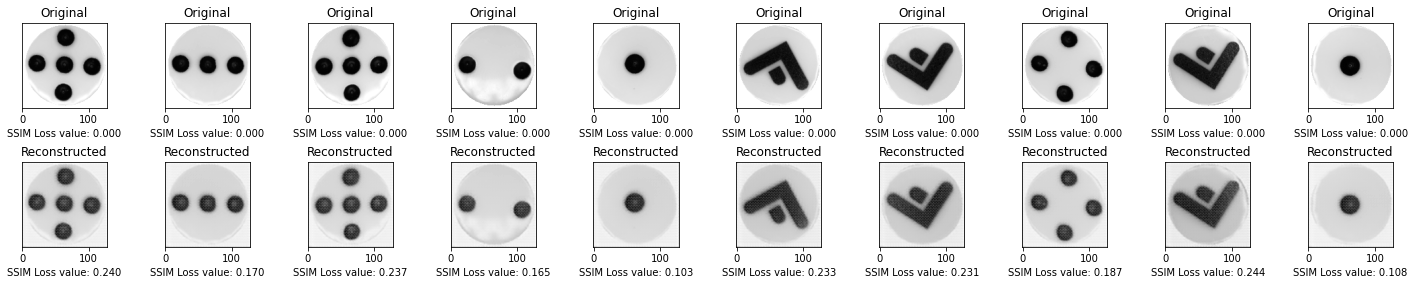

In [23]:
decoded_imgs = autoencoder.predict(test_data)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_data[i].reshape(128, 128))
    plt.gray()
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(test_data[i], test_data[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(decoded_imgs[i], test_data[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a))
plt.tight_layout()
plt.show()

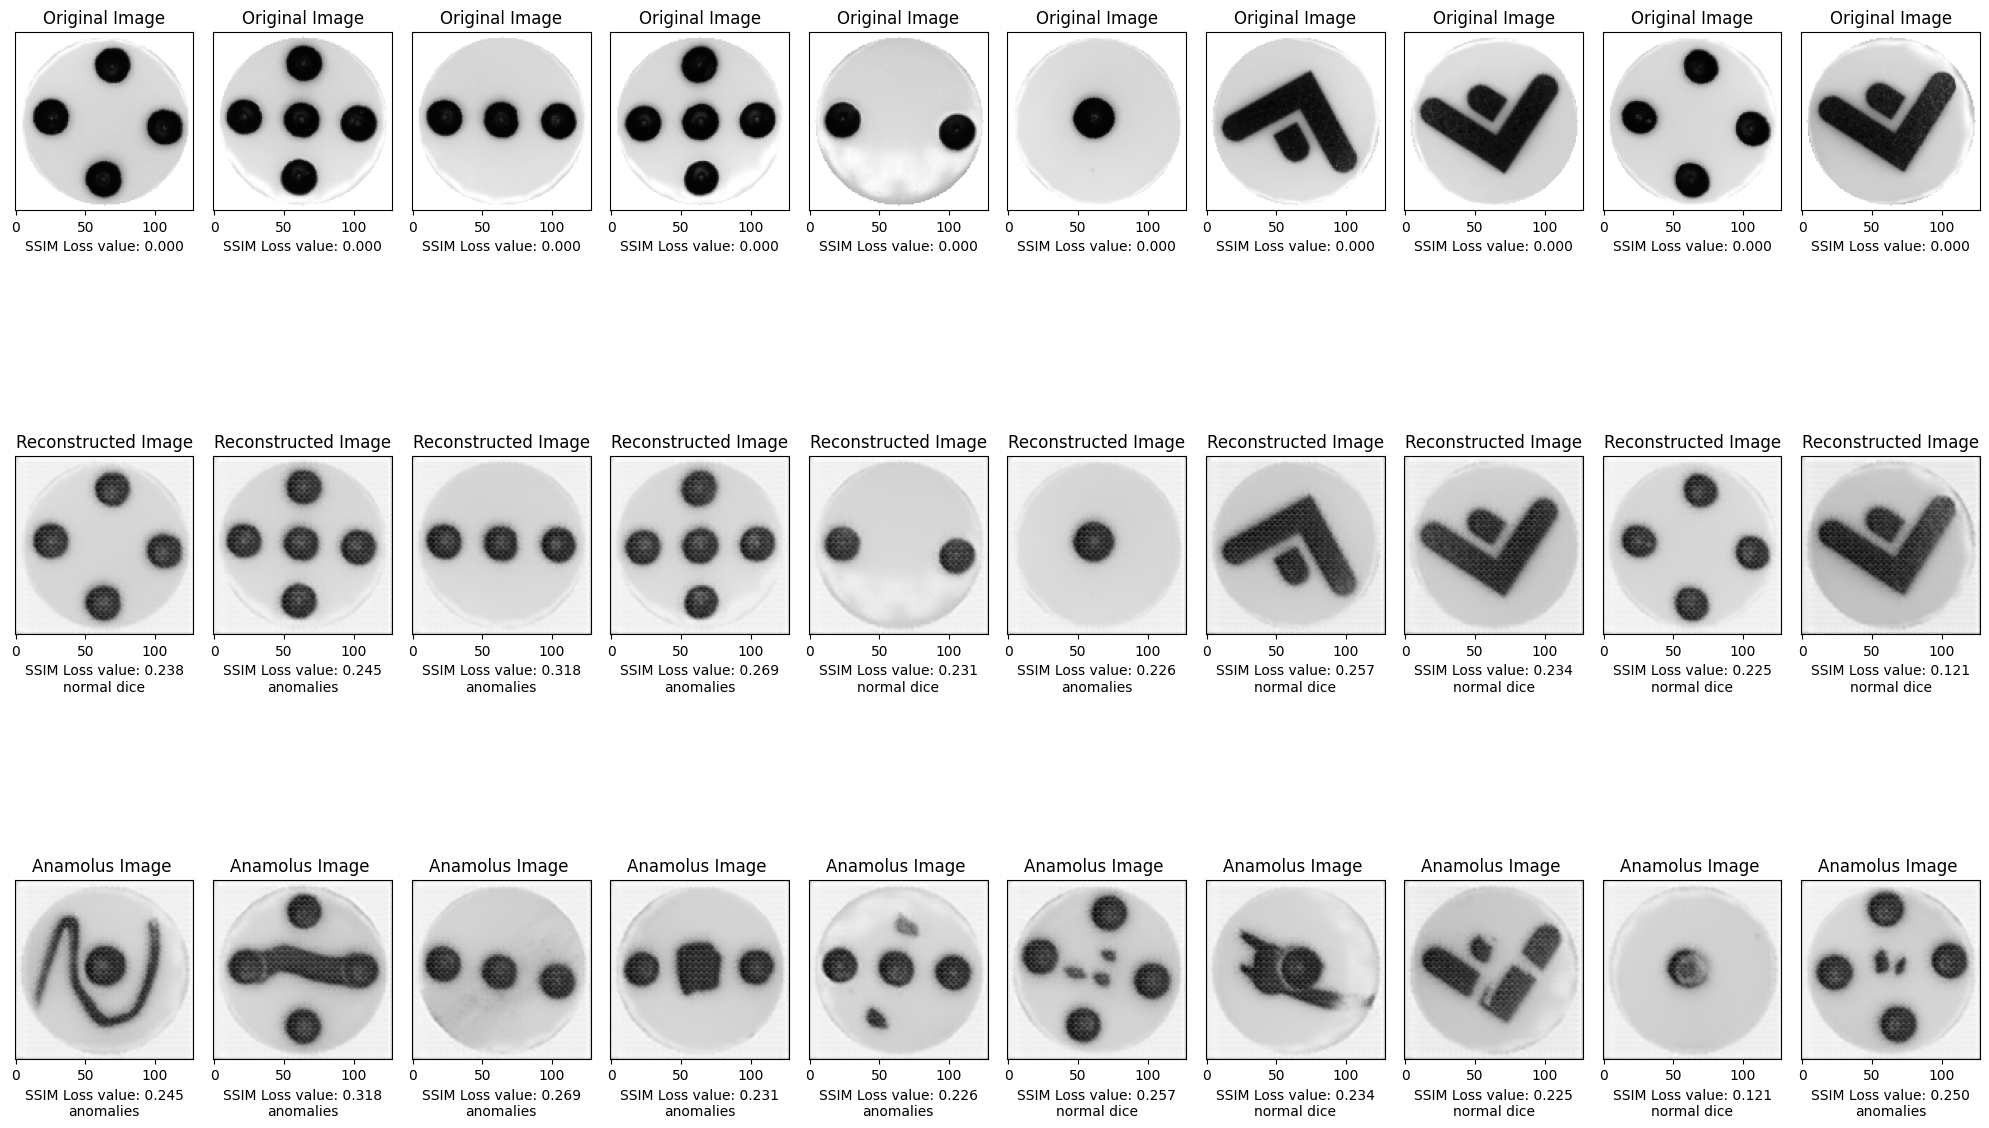

In [33]:
%matplotlib inline
class_model= tf.keras.models.load_model("../../models/preprocessed_data_cnn_model.h5")
    
n = 10 # how many encoded and decoded images we will display
decoded_imgs= autoencoder.predict(test_data)

decoded_mnistimgs= autoencoder.predict(anomalies)
plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1
for i in range(n):
    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(test_data[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(test_data[i], test_data[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed good data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n )
    plt.imshow(decoded_imgs[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = SSIMLoss(decoded_imgs[i], test_data[i])
    ax.set_title("Reconstructed Image")
    label = 'SSIM Loss value: {:.3f}\n{}'
    dice_class = class_model.predict(decoded_imgs[i].reshape(1,128, 128, 1)).argmax(axis=1)
    ano = 'anomalies' if value> threshold[dice_class[0]] else 'normal dice'
    ax.set_xlabel(label.format(value, ano) )
    # ax.set_xlabel(ano)
    
    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + 2*n)
    plt.imshow(decoded_mnistimgs[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(anomalies[i], decoded_mnistimgs[i])
    label = 'SSIM Loss value: {:.3f}\n{}'
    ax.set_title("Anamolus Image " )
    dice_class = class_model.predict(decoded_mnistimgs[i].reshape(1,128, 128, 1)).argmax(axis=1)
    ano = 'anomalies' if value> threshold[dice_class[0]] else 'normal dice'
    ax.set_xlabel(label.format(value,ano) )
    # ax.set_xlabel(ano)
    plt_a+=1
plt.tight_layout()
plt.show()

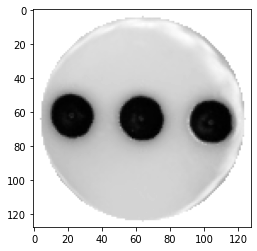

In [25]:
img = Image.open("../../processed_data/train_set/3/16_09_21_03_000.png")
plt.imshow(img, cmap="gray")
img = np.array(img)/255
decoded_imgs= autoencoder.predict(img.reshape(1,128, 128, 1))

(1, 128, 128, 1)


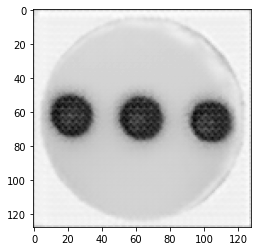

In [26]:
print(decoded_imgs.shape)
plt.imshow(decoded_imgs[0])